<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# Student : Mingyao Zhao

# Downloading Data and Preliminaries

In [22]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
from zipfile import ZipFile
import requests
import io


import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image
# ## Model Definition ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [6]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

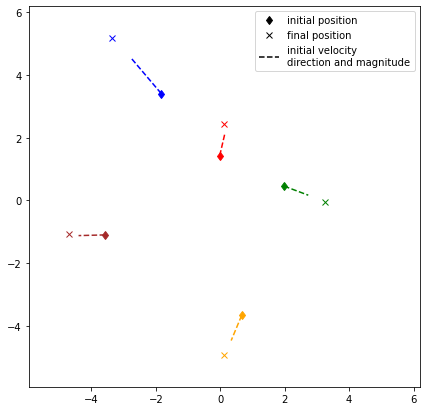

In [7]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [8]:
#todo

In [9]:
sim_idx = 42
t_idx = 3  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p} in time {t_idx/2}.\nThe initial velocity of this particle was {v}.'
)

In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.19160159 -1.50145464] in time 1.5.
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [10]:
def data_handling(positions_data,velocities_data,charges_data):
    total=[]
    for sim in range(len(positions_data)):
        sub=[]
        for time in range(4):
            a=positions_data[sim,time,(0,1),:].flatten()
            b=velocities_data[sim,0,(0,1),:].flatten()
            c=charges_data[sim,:,0]
            sub.append(np.concatenate((a,b,c),axis=-1).tolist())
        total.append(sub)
    return total

def feature_extract(data):
    features=[]
    for i in range(len(data)):
        features.append(data[i][0][:])
    return features


def label_extract(data):
    labels=[]
    for time in range(1,4):
        sub=[]
        for j in range(len(data)):
            sub.append(data[j][time][:10])     
        labels.append(sub)
    return labels

In [11]:

def get_dataset(positions,velocities,charges):
    data=data_handling(positions_data=positions,velocities_data=velocities,charges_data=charges)
    feature=feature_extract(data)
    label=label_extract(data)
    return feature,label
    

In [12]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data)
        self.targets = torch.tensor(targets)
           
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):  # get the label and data by index
        x = self.data[index]
        y = self.targets[index]
        return x, y

In [13]:
from sklearn.preprocessing import StandardScaler
def create_dataloader(positions,velocities,charges, batch_size):
    sc = StandardScaler()
    feature,label=get_dataset(positions=positions,velocities=velocities,charges=charges)
    feature = sc.fit_transform(feature)
    loader=[]
    for time in range(3):
        dataset=MyDataset(feature,label[time])
        loader.append(DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True))
    return loader

    


# Model Implementation

In [14]:
#todo
# check if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:

class Mynetwork(torch.nn.Module):
    def __init__(self):
        super(Mynetwork, self).__init__()     
        self.layer1 = torch.nn.Linear(25, 256)
        # self.layer2 = torch.nn.Linear(300, 500)
        # self.layer3 = torch.nn.Linear(500, 500)   
        self.layer4 = torch.nn.Linear(256, 64)   
        self.layer5 = torch.nn.Linear(64, 10)

    def forward(self, x):   
        # print(x.dtype)
        x = self.layer1(x)
        # x = torch.relu(x)      
        # x = self.layer2(x)
        # x = torch.sigmoid(x)   
        # x = self.layer3(x)
        x = torch.relu(x)    
        x = self.layer4(x)
        x = torch.relu(x) 
        x = self.layer5(x)
        # x = torch.relu(x) 
        return x

# Model Training

In [50]:

def train(model, num_epochs, loss_fuc,time,batch_size, data_length,optimizer):
    """
    Train the model.
    """
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loader=create_dataloader(positions=positions_train[0:data_length],velocities=velocities_train[0:data_length],charges=charges_train[0:data_length],batch_size=batch_size)
        valid_loader=create_dataloader(positions=positions_valid,velocities=velocities_valid,charges=charges_valid,batch_size=batch_size)
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for (features, labels) in train_loader[time]:
            # Forward
            # print(anchor.shape)
            (features, labels) = (features.to(device), labels.to(device))
            pred = model(features.float())
            loss = loss_fuc(pred, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_running_loss = 0.0

        # check validation loss after every epoch
        with torch.no_grad():
            model.eval()
            for (features, labels) in valid_loader[time]:
                (features, labels) = (features.to(device), labels.to(device))
                pred = model(features.float())
                loss = loss_fuc(pred, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(valid_loader)
        val_losses.append(avg_val_loss)

        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
              .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
    print("Finished Training")
    return train_losses, val_losses


In [30]:
def plot_loss(train_loss, val_loss,epoche,time):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train and validation loss from model{}".format(time))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, train_loss)
    plt.plot(epoche_range, val_loss)
    plt.legend(['train loss', 'validation loss'], loc='best')
    plt.show()

In [48]:
model0 = Mynetwork().to(device).float()
Loss= nn.MSELoss()
# Loss= nn.HuberLoss()
Batch_size=128
optimizer = torch.optim.SGD(model0.parameters(), lr=0.01)

epochs = 500
train_losses0,val_losses0=train(model=model0,num_epochs=epochs,loss_fuc=Loss,time=0,batch_size=Batch_size,data_length=100)

Starting epoch 1
Epoch [1/500],Train Loss: 2.7221, Valid Loss: 39.76686255
Starting epoch 2
Epoch [2/500],Train Loss: 2.7167, Valid Loss: 39.82284864
Starting epoch 3
Epoch [3/500],Train Loss: 2.7113, Valid Loss: 39.63158274
Starting epoch 4
Epoch [4/500],Train Loss: 2.7059, Valid Loss: 39.56665675
Starting epoch 5
Epoch [5/500],Train Loss: 2.7006, Valid Loss: 39.51624854
Starting epoch 6
Epoch [6/500],Train Loss: 2.6953, Valid Loss: 39.46859026
Starting epoch 7
Epoch [7/500],Train Loss: 2.6900, Valid Loss: 39.38617659
Starting epoch 8
Epoch [8/500],Train Loss: 2.6847, Valid Loss: 39.36411969
Starting epoch 9
Epoch [9/500],Train Loss: 2.6794, Valid Loss: 39.34089851
Starting epoch 10
Epoch [10/500],Train Loss: 2.6741, Valid Loss: 39.22716173
Starting epoch 11
Epoch [11/500],Train Loss: 2.6688, Valid Loss: 39.25914081
Starting epoch 12
Epoch [12/500],Train Loss: 2.6634, Valid Loss: 39.14831432
Starting epoch 13
Epoch [13/500],Train Loss: 2.6581, Valid Loss: 38.96277301
Starting epoch 14

Starting epoch 108
Epoch [108/500],Train Loss: 1.8507, Valid Loss: 31.33648094
Starting epoch 109
Epoch [109/500],Train Loss: 1.8391, Valid Loss: 31.24855709
Starting epoch 110
Epoch [110/500],Train Loss: 1.8275, Valid Loss: 31.09220966
Starting epoch 111
Epoch [111/500],Train Loss: 1.8158, Valid Loss: 31.05100552
Starting epoch 112
Epoch [112/500],Train Loss: 1.8042, Valid Loss: 30.85896111
Starting epoch 113
Epoch [113/500],Train Loss: 1.7925, Valid Loss: 30.62077522
Starting epoch 114
Epoch [114/500],Train Loss: 1.7809, Valid Loss: 30.65334161
Starting epoch 115
Epoch [115/500],Train Loss: 1.7692, Valid Loss: 30.50147549
Starting epoch 116
Epoch [116/500],Train Loss: 1.7575, Valid Loss: 30.28902435
Starting epoch 117
Epoch [117/500],Train Loss: 1.7459, Valid Loss: 30.18628804
Starting epoch 118
Epoch [118/500],Train Loss: 1.7342, Valid Loss: 30.10730251
Starting epoch 119
Epoch [119/500],Train Loss: 1.7225, Valid Loss: 30.06192176
Starting epoch 120
Epoch [120/500],Train Loss: 1.710

Epoch [213/500],Train Loss: 0.8568, Valid Loss: 19.37416649
Starting epoch 214
Epoch [214/500],Train Loss: 0.8506, Valid Loss: 19.18476860
Starting epoch 215
Epoch [215/500],Train Loss: 0.8445, Valid Loss: 19.14819193
Starting epoch 216
Epoch [216/500],Train Loss: 0.8384, Valid Loss: 19.09272091
Starting epoch 217
Epoch [217/500],Train Loss: 0.8324, Valid Loss: 18.93033051
Starting epoch 218
Epoch [218/500],Train Loss: 0.8264, Valid Loss: 19.00896271
Starting epoch 219
Epoch [219/500],Train Loss: 0.8205, Valid Loss: 18.72735659
Starting epoch 220
Epoch [220/500],Train Loss: 0.8146, Valid Loss: 18.70483796
Starting epoch 221
Epoch [221/500],Train Loss: 0.8088, Valid Loss: 18.71319612
Starting epoch 222
Epoch [222/500],Train Loss: 0.8030, Valid Loss: 18.50676886
Starting epoch 223
Epoch [223/500],Train Loss: 0.7972, Valid Loss: 18.42375000
Starting epoch 224
Epoch [224/500],Train Loss: 0.7916, Valid Loss: 18.35430368
Starting epoch 225
Epoch [225/500],Train Loss: 0.7859, Valid Loss: 18.2

Epoch [317/500],Train Loss: 0.4383, Valid Loss: 12.36964568
Starting epoch 318
Epoch [318/500],Train Loss: 0.4360, Valid Loss: 12.29471318
Starting epoch 319
Epoch [319/500],Train Loss: 0.4338, Valid Loss: 12.22945309
Starting epoch 320
Epoch [320/500],Train Loss: 0.4316, Valid Loss: 12.21313540
Starting epoch 321
Epoch [321/500],Train Loss: 0.4293, Valid Loss: 12.16470416
Starting epoch 322
Epoch [322/500],Train Loss: 0.4272, Valid Loss: 12.13509194
Starting epoch 323
Epoch [323/500],Train Loss: 0.4250, Valid Loss: 12.13116964
Starting epoch 324
Epoch [324/500],Train Loss: 0.4228, Valid Loss: 12.01382228
Starting epoch 325
Epoch [325/500],Train Loss: 0.4207, Valid Loss: 11.97213574
Starting epoch 326
Epoch [326/500],Train Loss: 0.4186, Valid Loss: 11.99077574
Starting epoch 327
Epoch [327/500],Train Loss: 0.4165, Valid Loss: 11.91730539
Starting epoch 328
Epoch [328/500],Train Loss: 0.4145, Valid Loss: 11.86452734
Starting epoch 329
Epoch [329/500],Train Loss: 0.4124, Valid Loss: 11.8

Epoch [423/500],Train Loss: 0.2755, Valid Loss: 8.93599204
Starting epoch 424
Epoch [424/500],Train Loss: 0.2744, Valid Loss: 8.87619158
Starting epoch 425
Epoch [425/500],Train Loss: 0.2733, Valid Loss: 8.85252806
Starting epoch 426
Epoch [426/500],Train Loss: 0.2723, Valid Loss: 8.82717983
Starting epoch 427
Epoch [427/500],Train Loss: 0.2712, Valid Loss: 8.77344767
Starting epoch 428
Epoch [428/500],Train Loss: 0.2702, Valid Loss: 8.81941708
Starting epoch 429
Epoch [429/500],Train Loss: 0.2691, Valid Loss: 8.76579889
Starting epoch 430
Epoch [430/500],Train Loss: 0.2681, Valid Loss: 8.76595386
Starting epoch 431
Epoch [431/500],Train Loss: 0.2671, Valid Loss: 8.69413773
Starting epoch 432
Epoch [432/500],Train Loss: 0.2660, Valid Loss: 8.71640865
Starting epoch 433
Epoch [433/500],Train Loss: 0.2650, Valid Loss: 8.66348871
Starting epoch 434
Epoch [434/500],Train Loss: 0.2640, Valid Loss: 8.68195387
Starting epoch 435
Epoch [435/500],Train Loss: 0.2630, Valid Loss: 8.61509542
Start

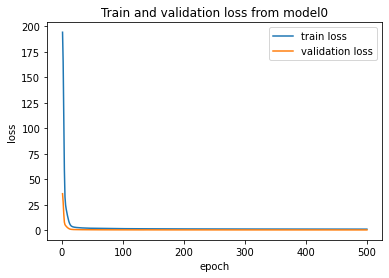

In [19]:
plot_loss(train_losses0,val_losses0,epoche=epochs,time=0)
# best:
# Epoch [50/50],Train Loss: 5.8402, Valid Loss: 1.25094794
# Epoch [50/50],Train Loss: 4.3375, Valid Loss: 1.00589175
# Epoch [50/50],Train Loss: 3.4852, Valid Loss: 0.83554913
# Epoch [50/50],Train Loss: 3.4256, Valid Loss: 0.82754069


In [20]:
model1 = Mynetwork().to(device).float()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01)
epochs = 500
train_losses1,val_losses1=train(model=model1,num_epochs=epochs,loss_fuc=Loss,time=1,batch_size=Batch_size)

Starting epoch 1
Epoch [1/500],Train Loss: 246.7864, Valid Loss: 44.93592771
Starting epoch 2
Epoch [2/500],Train Loss: 202.5687, Valid Loss: 32.69163386
Starting epoch 3
Epoch [3/500],Train Loss: 128.0660, Valid Loss: 17.60470319
Starting epoch 4
Epoch [4/500],Train Loss: 64.2999, Valid Loss: 8.86689524
Starting epoch 5
Epoch [5/500],Train Loss: 37.3078, Valid Loss: 6.33763214
Starting epoch 6
Epoch [6/500],Train Loss: 29.1752, Valid Loss: 5.33058035
Starting epoch 7
Epoch [7/500],Train Loss: 24.4282, Valid Loss: 4.53215637
Starting epoch 8
Epoch [8/500],Train Loss: 20.3058, Valid Loss: 3.71362579
Starting epoch 9
Epoch [9/500],Train Loss: 16.6614, Valid Loss: 3.04942975
Starting epoch 10
Epoch [10/500],Train Loss: 13.5783, Valid Loss: 2.49365241
Starting epoch 11
Epoch [11/500],Train Loss: 11.0269, Valid Loss: 2.10432082
Starting epoch 12
Epoch [12/500],Train Loss: 9.1322, Valid Loss: 1.77271945
Starting epoch 13
Epoch [13/500],Train Loss: 7.8868, Valid Loss: 1.56742538
Starting epoc

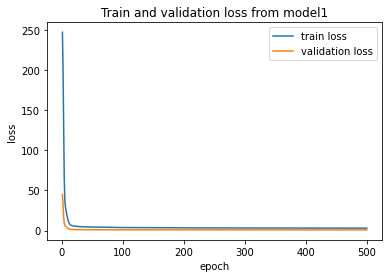

In [21]:
plot_loss(train_losses1,val_losses1,epoche=epochs,time=1)

In [22]:
model2 = Mynetwork().to(device).float()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)
epochs = 500
train_losses2,val_losses2=train(model=model2,num_epochs=epochs,loss_fuc=Loss,time=2,batch_size=Batch_size)

Starting epoch 1
Epoch [1/500],Train Loss: 311.0760, Valid Loss: 56.54182657
Starting epoch 2
Epoch [2/500],Train Loss: 252.9249, Valid Loss: 40.01079400
Starting epoch 3
Epoch [3/500],Train Loss: 146.1264, Valid Loss: 17.72105694
Starting epoch 4
Epoch [4/500],Train Loss: 63.1961, Valid Loss: 9.08605413
Starting epoch 5
Epoch [5/500],Train Loss: 40.2795, Valid Loss: 7.30418718
Starting epoch 6
Epoch [6/500],Train Loss: 33.7466, Valid Loss: 6.27148509
Starting epoch 7
Epoch [7/500],Train Loss: 28.8769, Valid Loss: 5.39962020
Starting epoch 8
Epoch [8/500],Train Loss: 24.4128, Valid Loss: 4.59771148
Starting epoch 9
Epoch [9/500],Train Loss: 20.3842, Valid Loss: 3.81731679
Starting epoch 10
Epoch [10/500],Train Loss: 16.8948, Valid Loss: 3.16257568
Starting epoch 11
Epoch [11/500],Train Loss: 14.2698, Valid Loss: 2.82175944
Starting epoch 12
Epoch [12/500],Train Loss: 12.2530, Valid Loss: 2.44316256
Starting epoch 13
Epoch [13/500],Train Loss: 11.1182, Valid Loss: 2.29248239
Starting ep

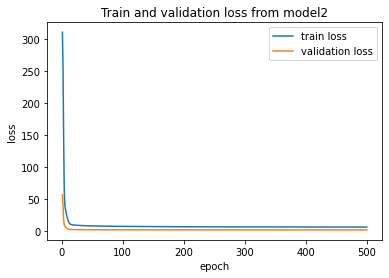

In [23]:
plot_loss(train_losses2,val_losses2,epoche=epochs,time=2)

# Evaluation

In [24]:
#todo
# model0=torch.load('D:/deeplearning/tue-deeplearning-main/assignments/assignment_2_3/model0.pt', map_location='cpu')
# model1=torch.load('D:/deeplearning/tue-deeplearning-main/assignments/assignment_2_3/model1.pt', map_location='cpu')
# model2=torch.load('D:/deeplearning/tue-deeplearning-main/assignments/assignment_2_3/model2.pt', map_location='cpu')

In [18]:
sim_idx = 42
t_idx = 1  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 0  # corresponds to particle with index 3

pt = positions_test[sim_idx, t_idx, spatial_idx, particle_idx]
p0 = positions_test[sim_idx, 0, spatial_idx, particle_idx]
v = velocities_test[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_test[sim_idx, particle_idx, 0] 


print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {pt} in time {t_idx/2}.\nThe initial velocity of this particle was {v}.\nThe initial position of this partical was {p0}')

In simulation 42 of the training set, particle 0 with charge -1.0 had coordinates [ 0.86874651 -0.88291407] in time 0.5.
The initial velocity of this particle was [1.88969779 0.72073123].
The initial position of this partical was [ 0.58549461 -0.9203365 ]


In [19]:
def plot_syb(pos, pos1, pos2):

    fig = plt.figure()
    axes = plt.gca()
    # axes.set_xlim([-5., 5.])
    # axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(5):
        plt.plot(pos[2*i], pos[2*i + 1], 'd', color=colors[i])
        plt.plot(pos1[2*i], pos1[2*i + 1], 'x', color=colors[i])
        plt.plot(pos2[2*i], pos2[2*i + 1], 'o', color=colors[i])
        # plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    # plt.xlim(np.min(pos)-1, np.max(pos) +1)
    # plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='Target position')
    plt.plot([], [], 'x', color='black', label='NN pred position')
    plt.plot([], [], 'o', color='black', label='Linear pred position')
    # plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

In [44]:
#test
feature_test,label_test=get_dataset(positions=positions_test,velocities=velocities_test,charges=charges_test)
sc = StandardScaler()
feature_test = (sc.fit_transform(feature_test))
# print(feature_test, label_test) : feature_test 2000,25       label_test 3,2000,10

#找出初始位置和初始速度
init_pos=[]
init_speed=[]
for i in range(len(feature_test)):
    init_pos.append(feature_test[i][:10])
    init_speed.append(feature_test[i][10:20])


#计算对应时间baseline5个粒子的位置  #0,1,2 代表0.5，1，1.5, 线性模型
def final_pos(time):
    pos=[]
    for i in range(len(init_speed)):
        sub=[]
        for j in range(len(init_speed[0])):
            sub.append(init_pos[i][j]+init_speed[i][j]*(time+1)/2)
        pos.append(sub)
    return pos
    

def distance(x1,x2):
    return np.linalg.norm(np.array(x1)- np.array(x2))

#0,1,2 代表0.5，1，1.5
def model_choose(time):
    # 选择模型
    model = model0
    if time==0:
        model=model0
    elif time==1:
        model=model1
    elif time==2:
        model==model2
    return model


# modelx=model_choose(time=2)

# 计算预测的位置
def pred_pos(model):
    modelx=model
    pos_pred=[]
    for i in range(len(feature_test)):
        pos_pred.append(modelx(torch.tensor(feature_test[i]).float()).tolist())
    return pos_pred


#计算两者与实际值的距离并进行准确率得分
def score(time, model):
    #提取baseline的位置
    baseline_pos=final_pos(time)
    #提取pred的位置
    pos_pred=pred_pos(model)

    score=0
    for i in range(len(feature_test)):
        pred_dis=distance(pos_pred[i],label_test[time][i])
        baseline_dis=distance(baseline_pos[i],label_test[time][i])
        if pred_dis<=baseline_dis:
            score+=1
    accuracy=score/len(feature_test)
    return accuracy


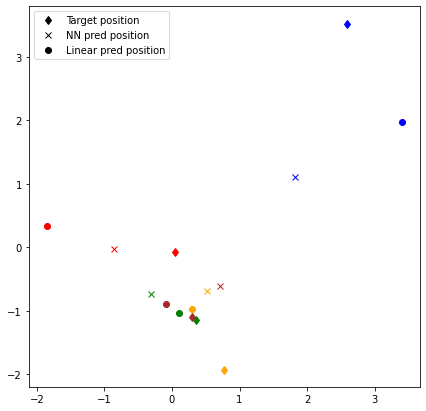

0.3445

In [33]:

model_choice = 2
ind = np.random.randint(0, 2000)
plot_syb(label_test[model_choice][ind], pred_pos(model_choice)[ind], final_pos(model_choice)[ind])
score(model_choice)

In [28]:
print('The accuracy of 0.5s position is ', score(0,model0))
print('The accuracy of 1.0s position is ', score(1,model1))
print('The accuracy of 1.5s position is ', score(2,model2))

The accuracy of 0.5s position is  1.0
The accuracy of 1.0s position is  1.0
The accuracy of 1.5s position is  0.9835


In [29]:
# 保存模型
torch.save(model0, './model0.pt')
torch.save(model1, './model1.pt')
torch.save(model2, './model2.pt')

In [51]:
#evaluate on different length
def train_length():
    model_list=[]
    for i in np.arange(2, 4, 0.5):
        Batch_size=128
        epochs = 500
        model0 = Mynetwork().to(device).float()
        model1 = Mynetwork().to(device).float()
        model2 = Mynetwork().to(device).float()
        optimizer0 = torch.optim.SGD(model0.parameters(), lr=0.01)  
        optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01)  
        optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01)  
        Loss= nn.MSELoss()
        
        train_losses,val_losses=train(model0,epochs,Loss,0,Batch_size, int(math.pow(10,i)),optimizer0)
        train_losses,val_losses=train(model1,epochs,Loss,1,Batch_size, int(math.pow(10,i)),optimizer1)
        train_losses,val_losses=train(model2,epochs,Loss,2,Batch_size, int(math.pow(10,i)),optimizer2)
        model_list.append([model0,model1,model2])
    return model_list


def evaluate_length(model_list):
    scores_list=[]
    for models in model_list:
        scores_list.append([score(0,models[0]),score(1,models[1]),score(2,models[2])])
    return scores_list

model_list = train_length()
score_list = evaluate_length(model_list)

Starting epoch 1
Epoch [1/500],Train Loss: 2.7082, Valid Loss: 39.43886455
Starting epoch 2
Epoch [2/500],Train Loss: 2.7027, Valid Loss: 39.31801097
Starting epoch 3
Epoch [3/500],Train Loss: 2.6972, Valid Loss: 39.40256071
Starting epoch 4
Epoch [4/500],Train Loss: 2.6918, Valid Loss: 39.26595513
Starting epoch 5
Epoch [5/500],Train Loss: 2.6864, Valid Loss: 39.52663565
Starting epoch 6
Epoch [6/500],Train Loss: 2.6810, Valid Loss: 39.27762413
Starting epoch 7
Epoch [7/500],Train Loss: 2.6756, Valid Loss: 39.20544243
Starting epoch 8
Epoch [8/500],Train Loss: 2.6704, Valid Loss: 39.22862816
Starting epoch 9
Epoch [9/500],Train Loss: 2.6653, Valid Loss: 39.22518444
Starting epoch 10
Epoch [10/500],Train Loss: 2.6604, Valid Loss: 39.05067253
Starting epoch 11
Epoch [11/500],Train Loss: 2.6555, Valid Loss: 39.22269567
Starting epoch 12
Epoch [12/500],Train Loss: 2.6506, Valid Loss: 38.93406884
Starting epoch 13
Epoch [13/500],Train Loss: 2.6457, Valid Loss: 38.88024743
Starting epoch 14

Starting epoch 109
Epoch [109/500],Train Loss: 1.7955, Valid Loss: 30.78329913
Starting epoch 110
Epoch [110/500],Train Loss: 1.7833, Valid Loss: 30.65859254
Starting epoch 111
Epoch [111/500],Train Loss: 1.7712, Valid Loss: 30.50102345
Starting epoch 112
Epoch [112/500],Train Loss: 1.7590, Valid Loss: 30.35521968
Starting epoch 113
Epoch [113/500],Train Loss: 1.7468, Valid Loss: 30.23470084
Starting epoch 114
Epoch [114/500],Train Loss: 1.7347, Valid Loss: 30.14502064
Starting epoch 115
Epoch [115/500],Train Loss: 1.7225, Valid Loss: 29.93535312
Starting epoch 116
Epoch [116/500],Train Loss: 1.7103, Valid Loss: 29.91522169
Starting epoch 117
Epoch [117/500],Train Loss: 1.6982, Valid Loss: 29.71492147
Starting epoch 118
Epoch [118/500],Train Loss: 1.6861, Valid Loss: 29.59688552
Starting epoch 119
Epoch [119/500],Train Loss: 1.6740, Valid Loss: 29.60695791
Starting epoch 120
Epoch [120/500],Train Loss: 1.6619, Valid Loss: 29.40020752
Starting epoch 121
Epoch [121/500],Train Loss: 1.649

Starting epoch 213
Epoch [213/500],Train Loss: 0.8005, Valid Loss: 18.33443507
Starting epoch 214
Epoch [214/500],Train Loss: 0.7946, Valid Loss: 18.20456521
Starting epoch 215
Epoch [215/500],Train Loss: 0.7887, Valid Loss: 18.17750883
Starting epoch 216
Epoch [216/500],Train Loss: 0.7829, Valid Loss: 18.12147919
Starting epoch 217
Epoch [217/500],Train Loss: 0.7771, Valid Loss: 17.90971859
Starting epoch 218
Epoch [218/500],Train Loss: 0.7714, Valid Loss: 17.90585303
Starting epoch 219
Epoch [219/500],Train Loss: 0.7658, Valid Loss: 17.82718706
Starting epoch 220
Epoch [220/500],Train Loss: 0.7602, Valid Loss: 17.62084214
Starting epoch 221
Epoch [221/500],Train Loss: 0.7547, Valid Loss: 17.56865239
Starting epoch 222
Epoch [222/500],Train Loss: 0.7492, Valid Loss: 17.51807062
Starting epoch 223
Epoch [223/500],Train Loss: 0.7438, Valid Loss: 17.39765620
Starting epoch 224
Epoch [224/500],Train Loss: 0.7385, Valid Loss: 17.40584302
Starting epoch 225
Epoch [225/500],Train Loss: 0.733

Starting epoch 317
Epoch [317/500],Train Loss: 0.4272, Valid Loss: 12.04251289
Starting epoch 318
Epoch [318/500],Train Loss: 0.4251, Valid Loss: 12.02115838
Starting epoch 319
Epoch [319/500],Train Loss: 0.4231, Valid Loss: 11.95633825
Starting epoch 320
Epoch [320/500],Train Loss: 0.4211, Valid Loss: 11.95095023
Starting epoch 321
Epoch [321/500],Train Loss: 0.4191, Valid Loss: 11.91833067
Starting epoch 322
Epoch [322/500],Train Loss: 0.4171, Valid Loss: 11.86786099
Starting epoch 323
Epoch [323/500],Train Loss: 0.4152, Valid Loss: 11.84109934
Starting epoch 324
Epoch [324/500],Train Loss: 0.4132, Valid Loss: 11.79310703
Starting epoch 325
Epoch [325/500],Train Loss: 0.4113, Valid Loss: 11.74178513
Starting epoch 326
Epoch [326/500],Train Loss: 0.4094, Valid Loss: 11.72378774
Starting epoch 327
Epoch [327/500],Train Loss: 0.4075, Valid Loss: 11.68027767
Starting epoch 328
Epoch [328/500],Train Loss: 0.4056, Valid Loss: 11.64826504
Starting epoch 329
Epoch [329/500],Train Loss: 0.403

Starting epoch 423
Epoch [423/500],Train Loss: 0.2708, Valid Loss: 8.83610582
Starting epoch 424
Epoch [424/500],Train Loss: 0.2697, Valid Loss: 8.85439026
Starting epoch 425
Epoch [425/500],Train Loss: 0.2686, Valid Loss: 8.81104056
Starting epoch 426
Epoch [426/500],Train Loss: 0.2675, Valid Loss: 8.77405083
Starting epoch 427
Epoch [427/500],Train Loss: 0.2664, Valid Loss: 8.77656241
Starting epoch 428
Epoch [428/500],Train Loss: 0.2654, Valid Loss: 8.72263984
Starting epoch 429
Epoch [429/500],Train Loss: 0.2643, Valid Loss: 8.71042097
Starting epoch 430
Epoch [430/500],Train Loss: 0.2632, Valid Loss: 8.75551216
Starting epoch 431
Epoch [431/500],Train Loss: 0.2622, Valid Loss: 8.63761520
Starting epoch 432
Epoch [432/500],Train Loss: 0.2611, Valid Loss: 8.63916993
Starting epoch 433
Epoch [433/500],Train Loss: 0.2601, Valid Loss: 8.61304855
Starting epoch 434
Epoch [434/500],Train Loss: 0.2591, Valid Loss: 8.62154031
Starting epoch 435
Epoch [435/500],Train Loss: 0.2580, Valid Los

Epoch [29/500],Train Loss: 3.3363, Valid Loss: 48.88595517
Starting epoch 30
Epoch [30/500],Train Loss: 3.3295, Valid Loss: 49.04701487
Starting epoch 31
Epoch [31/500],Train Loss: 3.3226, Valid Loss: 48.80747970
Starting epoch 32
Epoch [32/500],Train Loss: 3.3155, Valid Loss: 49.17731539
Starting epoch 33
Epoch [33/500],Train Loss: 3.3084, Valid Loss: 48.82592487
Starting epoch 34
Epoch [34/500],Train Loss: 3.3012, Valid Loss: 48.62596671
Starting epoch 35
Epoch [35/500],Train Loss: 3.2938, Valid Loss: 48.60073280
Starting epoch 36
Epoch [36/500],Train Loss: 3.2863, Valid Loss: 48.47669331
Starting epoch 37
Epoch [37/500],Train Loss: 3.2787, Valid Loss: 48.47618421
Starting epoch 38
Epoch [38/500],Train Loss: 3.2710, Valid Loss: 48.50546932
Starting epoch 39
Epoch [39/500],Train Loss: 3.2632, Valid Loss: 48.36829646
Starting epoch 40
Epoch [40/500],Train Loss: 3.2552, Valid Loss: 48.16732534
Starting epoch 41
Epoch [41/500],Train Loss: 3.2470, Valid Loss: 48.17227268
Starting epoch 42

Epoch [135/500],Train Loss: 1.9174, Valid Loss: 35.04358625
Starting epoch 136
Epoch [136/500],Train Loss: 1.9017, Valid Loss: 34.80975676
Starting epoch 137
Epoch [137/500],Train Loss: 1.8861, Valid Loss: 34.68837595
Starting epoch 138
Epoch [138/500],Train Loss: 1.8706, Valid Loss: 34.58435742
Starting epoch 139
Epoch [139/500],Train Loss: 1.8553, Valid Loss: 34.39063152
Starting epoch 140
Epoch [140/500],Train Loss: 1.8401, Valid Loss: 34.27625608
Starting epoch 141
Epoch [141/500],Train Loss: 1.8250, Valid Loss: 33.99506426
Starting epoch 142
Epoch [142/500],Train Loss: 1.8100, Valid Loss: 33.81017494
Starting epoch 143
Epoch [143/500],Train Loss: 1.7952, Valid Loss: 33.64974229
Starting epoch 144
Epoch [144/500],Train Loss: 1.7805, Valid Loss: 33.28503895
Starting epoch 145
Epoch [145/500],Train Loss: 1.7659, Valid Loss: 33.19584624
Starting epoch 146
Epoch [146/500],Train Loss: 1.7514, Valid Loss: 33.11011314
Starting epoch 147
Epoch [147/500],Train Loss: 1.7370, Valid Loss: 32.9

Epoch [239/500],Train Loss: 0.8329, Valid Loss: 20.33461181
Starting epoch 240
Epoch [240/500],Train Loss: 0.8265, Valid Loss: 20.22491129
Starting epoch 241
Epoch [241/500],Train Loss: 0.8201, Valid Loss: 20.04404314
Starting epoch 242
Epoch [242/500],Train Loss: 0.8138, Valid Loss: 20.00803359
Starting epoch 243
Epoch [243/500],Train Loss: 0.8075, Valid Loss: 19.91476758
Starting epoch 244
Epoch [244/500],Train Loss: 0.8013, Valid Loss: 19.75596682
Starting epoch 245
Epoch [245/500],Train Loss: 0.7951, Valid Loss: 19.71703339
Starting epoch 246
Epoch [246/500],Train Loss: 0.7890, Valid Loss: 19.66944321
Starting epoch 247
Epoch [247/500],Train Loss: 0.7830, Valid Loss: 19.52035356
Starting epoch 248
Epoch [248/500],Train Loss: 0.7770, Valid Loss: 19.48271600
Starting epoch 249
Epoch [249/500],Train Loss: 0.7710, Valid Loss: 19.29767783
Starting epoch 250
Epoch [250/500],Train Loss: 0.7652, Valid Loss: 19.25138481
Starting epoch 251
Epoch [251/500],Train Loss: 0.7593, Valid Loss: 19.2

Starting epoch 343
Epoch [343/500],Train Loss: 0.4147, Valid Loss: 12.95605858
Starting epoch 344
Epoch [344/500],Train Loss: 0.4125, Valid Loss: 12.97902862
Starting epoch 345
Epoch [345/500],Train Loss: 0.4103, Valid Loss: 12.84413497
Starting epoch 346
Epoch [346/500],Train Loss: 0.4082, Valid Loss: 12.76337087
Starting epoch 347
Epoch [347/500],Train Loss: 0.4061, Valid Loss: 12.74101837
Starting epoch 348
Epoch [348/500],Train Loss: 0.4040, Valid Loss: 12.70176792
Starting epoch 349
Epoch [349/500],Train Loss: 0.4019, Valid Loss: 12.68298682
Starting epoch 350
Epoch [350/500],Train Loss: 0.3998, Valid Loss: 12.63300482
Starting epoch 351
Epoch [351/500],Train Loss: 0.3978, Valid Loss: 12.59321531
Starting epoch 352
Epoch [352/500],Train Loss: 0.3958, Valid Loss: 12.56619016
Starting epoch 353
Epoch [353/500],Train Loss: 0.3938, Valid Loss: 12.47368503
Starting epoch 354
Epoch [354/500],Train Loss: 0.3918, Valid Loss: 12.45203463
Starting epoch 355
Epoch [355/500],Train Loss: 0.389

Starting epoch 448
Epoch [448/500],Train Loss: 0.2573, Valid Loss: 9.52658069
Starting epoch 449
Epoch [449/500],Train Loss: 0.2563, Valid Loss: 9.50367908
Starting epoch 450
Epoch [450/500],Train Loss: 0.2553, Valid Loss: 9.48691456
Starting epoch 451
Epoch [451/500],Train Loss: 0.2542, Valid Loss: 9.44253965
Starting epoch 452
Epoch [452/500],Train Loss: 0.2532, Valid Loss: 9.40588868
Starting epoch 453
Epoch [453/500],Train Loss: 0.2522, Valid Loss: 9.41870073
Starting epoch 454
Epoch [454/500],Train Loss: 0.2512, Valid Loss: 9.39737320
Starting epoch 455
Epoch [455/500],Train Loss: 0.2502, Valid Loss: 9.39822400
Starting epoch 456
Epoch [456/500],Train Loss: 0.2493, Valid Loss: 9.34149142
Starting epoch 457
Epoch [457/500],Train Loss: 0.2483, Valid Loss: 9.32234339
Starting epoch 458
Epoch [458/500],Train Loss: 0.2473, Valid Loss: 9.31885211
Starting epoch 459
Epoch [459/500],Train Loss: 0.2463, Valid Loss: 9.28485835
Starting epoch 460
Epoch [460/500],Train Loss: 0.2454, Valid Los

Epoch [54/500],Train Loss: 3.8123, Valid Loss: 58.19641622
Starting epoch 55
Epoch [55/500],Train Loss: 3.7955, Valid Loss: 57.65311495
Starting epoch 56
Epoch [56/500],Train Loss: 3.7784, Valid Loss: 57.70826626
Starting epoch 57
Epoch [57/500],Train Loss: 3.7610, Valid Loss: 57.44087474
Starting epoch 58
Epoch [58/500],Train Loss: 3.7433, Valid Loss: 57.15848891
Starting epoch 59
Epoch [59/500],Train Loss: 3.7252, Valid Loss: 57.18774478
Starting epoch 60
Epoch [60/500],Train Loss: 3.7070, Valid Loss: 56.94202010
Starting epoch 61
Epoch [61/500],Train Loss: 3.6884, Valid Loss: 56.86900520
Starting epoch 62
Epoch [62/500],Train Loss: 3.6697, Valid Loss: 56.66836802
Starting epoch 63
Epoch [63/500],Train Loss: 3.6506, Valid Loss: 56.51436838
Starting epoch 64
Epoch [64/500],Train Loss: 3.6313, Valid Loss: 56.28150050
Starting epoch 65
Epoch [65/500],Train Loss: 3.6116, Valid Loss: 56.33361530
Starting epoch 66
Epoch [66/500],Train Loss: 3.5917, Valid Loss: 56.39710172
Starting epoch 67

Epoch [159/500],Train Loss: 1.6701, Valid Loss: 35.27714300
Starting epoch 160
Epoch [160/500],Train Loss: 1.6523, Valid Loss: 34.93047698
Starting epoch 161
Epoch [161/500],Train Loss: 1.6346, Valid Loss: 34.66313759
Starting epoch 162
Epoch [162/500],Train Loss: 1.6171, Valid Loss: 34.63194529
Starting epoch 163
Epoch [163/500],Train Loss: 1.5996, Valid Loss: 34.28562546
Starting epoch 164
Epoch [164/500],Train Loss: 1.5823, Valid Loss: 34.02401018
Starting epoch 165
Epoch [165/500],Train Loss: 1.5651, Valid Loss: 33.80818351
Starting epoch 166
Epoch [166/500],Train Loss: 1.5480, Valid Loss: 33.50996335
Starting epoch 167
Epoch [167/500],Train Loss: 1.5311, Valid Loss: 33.22094250
Starting epoch 168
Epoch [168/500],Train Loss: 1.5143, Valid Loss: 33.05911620
Starting epoch 169
Epoch [169/500],Train Loss: 1.4977, Valid Loss: 32.66109006
Starting epoch 170
Epoch [170/500],Train Loss: 1.4812, Valid Loss: 32.55006727
Starting epoch 171
Epoch [171/500],Train Loss: 1.4648, Valid Loss: 32.2

Starting epoch 263
Epoch [263/500],Train Loss: 0.6547, Valid Loss: 19.16554197
Starting epoch 264
Epoch [264/500],Train Loss: 0.6510, Valid Loss: 19.13231365
Starting epoch 265
Epoch [265/500],Train Loss: 0.6473, Valid Loss: 18.94273154
Starting epoch 266
Epoch [266/500],Train Loss: 0.6437, Valid Loss: 18.94651143
Starting epoch 267
Epoch [267/500],Train Loss: 0.6401, Valid Loss: 18.95270681
Starting epoch 268
Epoch [268/500],Train Loss: 0.6366, Valid Loss: 18.80932887
Starting epoch 269
Epoch [269/500],Train Loss: 0.6331, Valid Loss: 18.72719510
Starting epoch 270
Epoch [270/500],Train Loss: 0.6296, Valid Loss: 18.61151910
Starting epoch 271
Epoch [271/500],Train Loss: 0.6262, Valid Loss: 18.57526120
Starting epoch 272
Epoch [272/500],Train Loss: 0.6228, Valid Loss: 18.62982551
Starting epoch 273
Epoch [273/500],Train Loss: 0.6195, Valid Loss: 18.44167121
Starting epoch 274
Epoch [274/500],Train Loss: 0.6162, Valid Loss: 18.49043544
Starting epoch 275
Epoch [275/500],Train Loss: 0.612

Epoch [367/500],Train Loss: 0.3937, Valid Loss: 13.74865238
Starting epoch 368
Epoch [368/500],Train Loss: 0.3919, Valid Loss: 13.76371447
Starting epoch 369
Epoch [369/500],Train Loss: 0.3902, Valid Loss: 13.66227047
Starting epoch 370
Epoch [370/500],Train Loss: 0.3885, Valid Loss: 13.68751677
Starting epoch 371
Epoch [371/500],Train Loss: 0.3869, Valid Loss: 13.57837534
Starting epoch 372
Epoch [372/500],Train Loss: 0.3852, Valid Loss: 13.52175220
Starting epoch 373
Epoch [373/500],Train Loss: 0.3835, Valid Loss: 13.48816760
Starting epoch 374
Epoch [374/500],Train Loss: 0.3819, Valid Loss: 13.43925714
Starting epoch 375
Epoch [375/500],Train Loss: 0.3803, Valid Loss: 13.39804093
Starting epoch 376
Epoch [376/500],Train Loss: 0.3787, Valid Loss: 13.40185436
Starting epoch 377
Epoch [377/500],Train Loss: 0.3771, Valid Loss: 13.39374487
Starting epoch 378
Epoch [378/500],Train Loss: 0.3755, Valid Loss: 13.35625545
Starting epoch 379
Epoch [379/500],Train Loss: 0.3739, Valid Loss: 13.3

Starting epoch 471
Epoch [471/500],Train Loss: 0.2663, Valid Loss: 10.92068092
Starting epoch 472
Epoch [472/500],Train Loss: 0.2654, Valid Loss: 10.95334351
Starting epoch 473
Epoch [473/500],Train Loss: 0.2645, Valid Loss: 10.85556126
Starting epoch 474
Epoch [474/500],Train Loss: 0.2636, Valid Loss: 10.85539329
Starting epoch 475
Epoch [475/500],Train Loss: 0.2628, Valid Loss: 10.85675482
Starting epoch 476
Epoch [476/500],Train Loss: 0.2619, Valid Loss: 10.85266419
Starting epoch 477
Epoch [477/500],Train Loss: 0.2611, Valid Loss: 10.79581805
Starting epoch 478
Epoch [478/500],Train Loss: 0.2602, Valid Loss: 10.77872101
Starting epoch 479
Epoch [479/500],Train Loss: 0.2594, Valid Loss: 10.78589400
Starting epoch 480
Epoch [480/500],Train Loss: 0.2585, Valid Loss: 10.75147919
Starting epoch 481
Epoch [481/500],Train Loss: 0.2577, Valid Loss: 10.73320917
Starting epoch 482
Epoch [482/500],Train Loss: 0.2569, Valid Loss: 10.70436553
Starting epoch 483
Epoch [483/500],Train Loss: 0.256

Starting epoch 77
Epoch [77/500],Train Loss: 3.0442, Valid Loss: 18.25542808
Starting epoch 78
Epoch [78/500],Train Loss: 2.9475, Valid Loss: 17.87314336
Starting epoch 79
Epoch [79/500],Train Loss: 2.8751, Valid Loss: 17.58351413
Starting epoch 80
Epoch [80/500],Train Loss: 2.7421, Valid Loss: 17.15860383
Starting epoch 81
Epoch [81/500],Train Loss: 2.7566, Valid Loss: 16.76587860
Starting epoch 82
Epoch [82/500],Train Loss: 2.6247, Valid Loss: 16.39503821
Starting epoch 83
Epoch [83/500],Train Loss: 2.5434, Valid Loss: 16.11361027
Starting epoch 84
Epoch [84/500],Train Loss: 2.5618, Valid Loss: 15.78861713
Starting epoch 85
Epoch [85/500],Train Loss: 2.4356, Valid Loss: 15.42165335
Starting epoch 86
Epoch [86/500],Train Loss: 2.3884, Valid Loss: 15.14509869
Starting epoch 87
Epoch [87/500],Train Loss: 2.3619, Valid Loss: 14.91502603
Starting epoch 88
Epoch [88/500],Train Loss: 2.2684, Valid Loss: 14.57029780
Starting epoch 89
Epoch [89/500],Train Loss: 2.2404, Valid Loss: 14.23736707

Starting epoch 184
Epoch [184/500],Train Loss: 0.5911, Valid Loss: 4.40899058
Starting epoch 185
Epoch [185/500],Train Loss: 0.5736, Valid Loss: 4.37328420
Starting epoch 186
Epoch [186/500],Train Loss: 0.5702, Valid Loss: 4.35969140
Starting epoch 187
Epoch [187/500],Train Loss: 0.5806, Valid Loss: 4.31125881
Starting epoch 188
Epoch [188/500],Train Loss: 0.5611, Valid Loss: 4.27143572
Starting epoch 189
Epoch [189/500],Train Loss: 0.5606, Valid Loss: 4.28266698
Starting epoch 190
Epoch [190/500],Train Loss: 0.5572, Valid Loss: 4.23448173
Starting epoch 191
Epoch [191/500],Train Loss: 0.5305, Valid Loss: 4.21582127
Starting epoch 192
Epoch [192/500],Train Loss: 0.5309, Valid Loss: 4.18572279
Starting epoch 193
Epoch [193/500],Train Loss: 0.5288, Valid Loss: 4.13742234
Starting epoch 194
Epoch [194/500],Train Loss: 0.5337, Valid Loss: 4.12096995
Starting epoch 195
Epoch [195/500],Train Loss: 0.5252, Valid Loss: 4.10991933
Starting epoch 196
Epoch [196/500],Train Loss: 0.5193, Valid Los

Starting epoch 290
Epoch [290/500],Train Loss: 0.2039, Valid Loss: 2.30713187
Starting epoch 291
Epoch [291/500],Train Loss: 0.2034, Valid Loss: 2.29929513
Starting epoch 292
Epoch [292/500],Train Loss: 0.2029, Valid Loss: 2.27284846
Starting epoch 293
Epoch [293/500],Train Loss: 0.2026, Valid Loss: 2.27429169
Starting epoch 294
Epoch [294/500],Train Loss: 0.1991, Valid Loss: 2.26700343
Starting epoch 295
Epoch [295/500],Train Loss: 0.1968, Valid Loss: 2.25358821
Starting epoch 296
Epoch [296/500],Train Loss: 0.1973, Valid Loss: 2.23564186
Starting epoch 297
Epoch [297/500],Train Loss: 0.1955, Valid Loss: 2.23682439
Starting epoch 298
Epoch [298/500],Train Loss: 0.1953, Valid Loss: 2.22017406
Starting epoch 299
Epoch [299/500],Train Loss: 0.1915, Valid Loss: 2.21716860
Starting epoch 300
Epoch [300/500],Train Loss: 0.1895, Valid Loss: 2.20046586
Starting epoch 301
Epoch [301/500],Train Loss: 0.1945, Valid Loss: 2.20305806
Starting epoch 302
Epoch [302/500],Train Loss: 0.1832, Valid Los

Starting epoch 397
Epoch [397/500],Train Loss: 0.1087, Valid Loss: 1.65334017
Starting epoch 398
Epoch [398/500],Train Loss: 0.1068, Valid Loss: 1.64262515
Starting epoch 399
Epoch [399/500],Train Loss: 0.1093, Valid Loss: 1.62935239
Starting epoch 400
Epoch [400/500],Train Loss: 0.1083, Valid Loss: 1.61877308
Starting epoch 401
Epoch [401/500],Train Loss: 0.1074, Valid Loss: 1.63145735
Starting epoch 402
Epoch [402/500],Train Loss: 0.1064, Valid Loss: 1.62761519
Starting epoch 403
Epoch [403/500],Train Loss: 0.1042, Valid Loss: 1.62389426
Starting epoch 404
Epoch [404/500],Train Loss: 0.1019, Valid Loss: 1.62644410
Starting epoch 405
Epoch [405/500],Train Loss: 0.1053, Valid Loss: 1.62256895
Starting epoch 406
Epoch [406/500],Train Loss: 0.1033, Valid Loss: 1.62952605
Starting epoch 407
Epoch [407/500],Train Loss: 0.1043, Valid Loss: 1.62683311
Starting epoch 408
Epoch [408/500],Train Loss: 0.1037, Valid Loss: 1.62448510
Starting epoch 409
Epoch [409/500],Train Loss: 0.1019, Valid Los

Starting epoch 2
Epoch [2/500],Train Loss: 9.9877, Valid Loss: 50.60257435
Starting epoch 3
Epoch [3/500],Train Loss: 9.6555, Valid Loss: 50.25705401
Starting epoch 4
Epoch [4/500],Train Loss: 9.4582, Valid Loss: 50.16683420
Starting epoch 5
Epoch [5/500],Train Loss: 9.1490, Valid Loss: 49.98297819
Starting epoch 6
Epoch [6/500],Train Loss: 9.2322, Valid Loss: 49.76896477
Starting epoch 7
Epoch [7/500],Train Loss: 9.6153, Valid Loss: 49.61256123
Starting epoch 8
Epoch [8/500],Train Loss: 9.5018, Valid Loss: 49.62421703
Starting epoch 9
Epoch [9/500],Train Loss: 9.2461, Valid Loss: 49.29917971
Starting epoch 10
Epoch [10/500],Train Loss: 9.2944, Valid Loss: 49.37564182
Starting epoch 11
Epoch [11/500],Train Loss: 9.2267, Valid Loss: 49.05346473
Starting epoch 12
Epoch [12/500],Train Loss: 9.0537, Valid Loss: 48.59664790
Starting epoch 13
Epoch [13/500],Train Loss: 9.4909, Valid Loss: 48.67328707
Starting epoch 14
Epoch [14/500],Train Loss: 9.2288, Valid Loss: 48.40348641
Starting epoch 

Starting epoch 110
Epoch [110/500],Train Loss: 1.5106, Valid Loss: 10.59879955
Starting epoch 111
Epoch [111/500],Train Loss: 1.5017, Valid Loss: 10.44997577
Starting epoch 112
Epoch [112/500],Train Loss: 1.4663, Valid Loss: 10.30229068
Starting epoch 113
Epoch [113/500],Train Loss: 1.4708, Valid Loss: 10.12497703
Starting epoch 114
Epoch [114/500],Train Loss: 1.4148, Valid Loss: 10.01117245
Starting epoch 115
Epoch [115/500],Train Loss: 1.4227, Valid Loss: 9.87011600
Starting epoch 116
Epoch [116/500],Train Loss: 1.3813, Valid Loss: 9.68547797
Starting epoch 117
Epoch [117/500],Train Loss: 1.3703, Valid Loss: 9.58346947
Starting epoch 118
Epoch [118/500],Train Loss: 1.3339, Valid Loss: 9.44091551
Starting epoch 119
Epoch [119/500],Train Loss: 1.3058, Valid Loss: 9.27468308
Starting epoch 120
Epoch [120/500],Train Loss: 1.3428, Valid Loss: 9.21339810
Starting epoch 121
Epoch [121/500],Train Loss: 1.2932, Valid Loss: 9.08831302
Starting epoch 122
Epoch [122/500],Train Loss: 1.2789, Vali

Starting epoch 216
Epoch [216/500],Train Loss: 0.5498, Valid Loss: 4.68169087
Starting epoch 217
Epoch [217/500],Train Loss: 0.5384, Valid Loss: 4.69791873
Starting epoch 218
Epoch [218/500],Train Loss: 0.5412, Valid Loss: 4.65890167
Starting epoch 219
Epoch [219/500],Train Loss: 0.5450, Valid Loss: 4.61184982
Starting epoch 220
Epoch [220/500],Train Loss: 0.5434, Valid Loss: 4.59993225
Starting epoch 221
Epoch [221/500],Train Loss: 0.5220, Valid Loss: 4.60535399
Starting epoch 222
Epoch [222/500],Train Loss: 0.5199, Valid Loss: 4.57035788
Starting epoch 223
Epoch [223/500],Train Loss: 0.5213, Valid Loss: 4.51315773
Starting epoch 224
Epoch [224/500],Train Loss: 0.4969, Valid Loss: 4.48128245
Starting epoch 225
Epoch [225/500],Train Loss: 0.5130, Valid Loss: 4.46798964
Starting epoch 226
Epoch [226/500],Train Loss: 0.5056, Valid Loss: 4.43243494
Starting epoch 227
Epoch [227/500],Train Loss: 0.4937, Valid Loss: 4.37829949
Starting epoch 228
Epoch [228/500],Train Loss: 0.4899, Valid Los

Starting epoch 322
Epoch [322/500],Train Loss: 0.2313, Valid Loss: 2.82297442
Starting epoch 323
Epoch [323/500],Train Loss: 0.2346, Valid Loss: 2.83280275
Starting epoch 324
Epoch [324/500],Train Loss: 0.2211, Valid Loss: 2.80169292
Starting epoch 325
Epoch [325/500],Train Loss: 0.2243, Valid Loss: 2.78214930
Starting epoch 326
Epoch [326/500],Train Loss: 0.2228, Valid Loss: 2.77504578
Starting epoch 327
Epoch [327/500],Train Loss: 0.2252, Valid Loss: 2.75095109
Starting epoch 328
Epoch [328/500],Train Loss: 0.2199, Valid Loss: 2.75629009
Starting epoch 329
Epoch [329/500],Train Loss: 0.2211, Valid Loss: 2.75368319
Starting epoch 330
Epoch [330/500],Train Loss: 0.2186, Valid Loss: 2.75426630
Starting epoch 331
Epoch [331/500],Train Loss: 0.2153, Valid Loss: 2.73675153
Starting epoch 332
Epoch [332/500],Train Loss: 0.2218, Valid Loss: 2.73812700
Starting epoch 333
Epoch [333/500],Train Loss: 0.2147, Valid Loss: 2.74328546
Starting epoch 334
Epoch [334/500],Train Loss: 0.2197, Valid Los

Starting epoch 429
Epoch [429/500],Train Loss: 0.1548, Valid Loss: 2.25703655
Starting epoch 430
Epoch [430/500],Train Loss: 0.1510, Valid Loss: 2.26644387
Starting epoch 431
Epoch [431/500],Train Loss: 0.1541, Valid Loss: 2.26204919
Starting epoch 432
Epoch [432/500],Train Loss: 0.1490, Valid Loss: 2.24370374
Starting epoch 433
Epoch [433/500],Train Loss: 0.1539, Valid Loss: 2.25832699
Starting epoch 434
Epoch [434/500],Train Loss: 0.1475, Valid Loss: 2.24779770
Starting epoch 435
Epoch [435/500],Train Loss: 0.1511, Valid Loss: 2.22578511
Starting epoch 436
Epoch [436/500],Train Loss: 0.1500, Valid Loss: 2.23314183
Starting epoch 437
Epoch [437/500],Train Loss: 0.1477, Valid Loss: 2.25693574
Starting epoch 438
Epoch [438/500],Train Loss: 0.1494, Valid Loss: 2.22678635
Starting epoch 439
Epoch [439/500],Train Loss: 0.1469, Valid Loss: 2.23653002
Starting epoch 440
Epoch [440/500],Train Loss: 0.1485, Valid Loss: 2.23256909
Starting epoch 441
Epoch [441/500],Train Loss: 0.1496, Valid Los

Starting epoch 36
Epoch [36/500],Train Loss: 8.9053, Valid Loss: 48.73487091
Starting epoch 37
Epoch [37/500],Train Loss: 8.7604, Valid Loss: 47.60370064
Starting epoch 38
Epoch [38/500],Train Loss: 8.5148, Valid Loss: 46.84253470
Starting epoch 39
Epoch [39/500],Train Loss: 8.6489, Valid Loss: 46.13691203
Starting epoch 40
Epoch [40/500],Train Loss: 8.4403, Valid Loss: 45.48207982
Starting epoch 41
Epoch [41/500],Train Loss: 8.1396, Valid Loss: 44.65509001
Starting epoch 42
Epoch [42/500],Train Loss: 8.3035, Valid Loss: 43.98404916
Starting epoch 43
Epoch [43/500],Train Loss: 7.7028, Valid Loss: 42.80766137
Starting epoch 44
Epoch [44/500],Train Loss: 7.7811, Valid Loss: 42.18940560
Starting epoch 45
Epoch [45/500],Train Loss: 7.3944, Valid Loss: 41.25162506
Starting epoch 46
Epoch [46/500],Train Loss: 7.3477, Valid Loss: 40.45350202
Starting epoch 47
Epoch [47/500],Train Loss: 6.9178, Valid Loss: 39.59515047
Starting epoch 48
Epoch [48/500],Train Loss: 6.8677, Valid Loss: 38.58464559

Starting epoch 143
Epoch [143/500],Train Loss: 1.0792, Valid Loss: 7.86481555
Starting epoch 144
Epoch [144/500],Train Loss: 1.0636, Valid Loss: 7.81437055
Starting epoch 145
Epoch [145/500],Train Loss: 1.0551, Valid Loss: 7.80283638
Starting epoch 146
Epoch [146/500],Train Loss: 1.0635, Valid Loss: 7.75145686
Starting epoch 147
Epoch [147/500],Train Loss: 1.0452, Valid Loss: 7.73717030
Starting epoch 148
Epoch [148/500],Train Loss: 1.0435, Valid Loss: 7.65804152
Starting epoch 149
Epoch [149/500],Train Loss: 1.0438, Valid Loss: 7.67110280
Starting epoch 150
Epoch [150/500],Train Loss: 1.0332, Valid Loss: 7.60832322
Starting epoch 151
Epoch [151/500],Train Loss: 1.0223, Valid Loss: 7.59045235
Starting epoch 152
Epoch [152/500],Train Loss: 1.0162, Valid Loss: 7.53499023
Starting epoch 153
Epoch [153/500],Train Loss: 1.0122, Valid Loss: 7.42499904
Starting epoch 154
Epoch [154/500],Train Loss: 0.9857, Valid Loss: 7.44922833
Starting epoch 155
Epoch [155/500],Train Loss: 0.9903, Valid Los

Starting epoch 250
Epoch [250/500],Train Loss: 0.4213, Valid Loss: 4.42837584
Starting epoch 251
Epoch [251/500],Train Loss: 0.4115, Valid Loss: 4.44489777
Starting epoch 252
Epoch [252/500],Train Loss: 0.4045, Valid Loss: 4.39500187
Starting epoch 253
Epoch [253/500],Train Loss: 0.4087, Valid Loss: 4.41963557
Starting epoch 254
Epoch [254/500],Train Loss: 0.4044, Valid Loss: 4.39853072
Starting epoch 255
Epoch [255/500],Train Loss: 0.3981, Valid Loss: 4.38903364
Starting epoch 256
Epoch [256/500],Train Loss: 0.3960, Valid Loss: 4.32993104
Starting epoch 257
Epoch [257/500],Train Loss: 0.3885, Valid Loss: 4.33807371
Starting epoch 258
Epoch [258/500],Train Loss: 0.3981, Valid Loss: 4.27921842
Starting epoch 259
Epoch [259/500],Train Loss: 0.3875, Valid Loss: 4.21687420
Starting epoch 260
Epoch [260/500],Train Loss: 0.3856, Valid Loss: 4.26640387
Starting epoch 261
Epoch [261/500],Train Loss: 0.3798, Valid Loss: 4.22719220
Starting epoch 262
Epoch [262/500],Train Loss: 0.3747, Valid Los

Starting epoch 357
Epoch [357/500],Train Loss: 0.2426, Valid Loss: 3.42770880
Starting epoch 358
Epoch [358/500],Train Loss: 0.2452, Valid Loss: 3.41344007
Starting epoch 359
Epoch [359/500],Train Loss: 0.2418, Valid Loss: 3.42551986
Starting epoch 360
Epoch [360/500],Train Loss: 0.2366, Valid Loss: 3.41840512
Starting epoch 361
Epoch [361/500],Train Loss: 0.2388, Valid Loss: 3.41657188
Starting epoch 362
Epoch [362/500],Train Loss: 0.2419, Valid Loss: 3.42334044
Starting epoch 363
Epoch [363/500],Train Loss: 0.2459, Valid Loss: 3.42770962
Starting epoch 364
Epoch [364/500],Train Loss: 0.2369, Valid Loss: 3.41140719
Starting epoch 365
Epoch [365/500],Train Loss: 0.2375, Valid Loss: 3.41514216
Starting epoch 366
Epoch [366/500],Train Loss: 0.2385, Valid Loss: 3.38221413
Starting epoch 367
Epoch [367/500],Train Loss: 0.2315, Valid Loss: 3.39037100
Starting epoch 368
Epoch [368/500],Train Loss: 0.2367, Valid Loss: 3.38088514
Starting epoch 369
Epoch [369/500],Train Loss: 0.2397, Valid Los

Starting epoch 463
Epoch [463/500],Train Loss: 0.1992, Valid Loss: 3.19091517
Starting epoch 464
Epoch [464/500],Train Loss: 0.1950, Valid Loss: 3.22471788
Starting epoch 465
Epoch [465/500],Train Loss: 0.1936, Valid Loss: 3.19180373
Starting epoch 466
Epoch [466/500],Train Loss: 0.1968, Valid Loss: 3.20668147
Starting epoch 467
Epoch [467/500],Train Loss: 0.1956, Valid Loss: 3.21424029
Starting epoch 468
Epoch [468/500],Train Loss: 0.1971, Valid Loss: 3.19233944
Starting epoch 469
Epoch [469/500],Train Loss: 0.1955, Valid Loss: 3.18737350
Starting epoch 470
Epoch [470/500],Train Loss: 0.1985, Valid Loss: 3.16566304
Starting epoch 471
Epoch [471/500],Train Loss: 0.1948, Valid Loss: 3.19428106
Starting epoch 472
Epoch [472/500],Train Loss: 0.1910, Valid Loss: 3.18060154
Starting epoch 473
Epoch [473/500],Train Loss: 0.1940, Valid Loss: 3.18459258
Starting epoch 474
Epoch [474/500],Train Loss: 0.1974, Valid Loss: 3.19106996
Starting epoch 475
Epoch [475/500],Train Loss: 0.1925, Valid Los

Epoch [69/500],Train Loss: 1.7751, Valid Loss: 3.92949647
Starting epoch 70
Epoch [70/500],Train Loss: 1.7414, Valid Loss: 3.82961257
Starting epoch 71
Epoch [71/500],Train Loss: 1.7050, Valid Loss: 3.77967270
Starting epoch 72
Epoch [72/500],Train Loss: 1.6755, Valid Loss: 3.71132459
Starting epoch 73
Epoch [73/500],Train Loss: 1.6418, Valid Loss: 3.64565742
Starting epoch 74
Epoch [74/500],Train Loss: 1.6018, Valid Loss: 3.56942328
Starting epoch 75
Epoch [75/500],Train Loss: 1.5670, Valid Loss: 3.50793143
Starting epoch 76
Epoch [76/500],Train Loss: 1.5366, Valid Loss: 3.43265506
Starting epoch 77
Epoch [77/500],Train Loss: 1.5064, Valid Loss: 3.36094413
Starting epoch 78
Epoch [78/500],Train Loss: 1.4689, Valid Loss: 3.30099054
Starting epoch 79
Epoch [79/500],Train Loss: 1.4410, Valid Loss: 3.24504750
Starting epoch 80
Epoch [80/500],Train Loss: 1.4111, Valid Loss: 3.18291688
Starting epoch 81
Epoch [81/500],Train Loss: 1.3801, Valid Loss: 3.12213316
Starting epoch 82
Epoch [82/50

Starting epoch 177
Epoch [177/500],Train Loss: 0.3003, Valid Loss: 0.89800443
Starting epoch 178
Epoch [178/500],Train Loss: 0.2980, Valid Loss: 0.89725992
Starting epoch 179
Epoch [179/500],Train Loss: 0.2950, Valid Loss: 0.89028032
Starting epoch 180
Epoch [180/500],Train Loss: 0.2945, Valid Loss: 0.88777706
Starting epoch 181
Epoch [181/500],Train Loss: 0.2931, Valid Loss: 0.89211910
Starting epoch 182
Epoch [182/500],Train Loss: 0.2908, Valid Loss: 0.87389830
Starting epoch 183
Epoch [183/500],Train Loss: 0.2907, Valid Loss: 0.86663922
Starting epoch 184
Epoch [184/500],Train Loss: 0.2884, Valid Loss: 0.86796736
Starting epoch 185
Epoch [185/500],Train Loss: 0.2868, Valid Loss: 0.86985757
Starting epoch 186
Epoch [186/500],Train Loss: 0.2854, Valid Loss: 0.85742618
Starting epoch 187
Epoch [187/500],Train Loss: 0.2834, Valid Loss: 0.86068490
Starting epoch 188
Epoch [188/500],Train Loss: 0.2830, Valid Loss: 0.86174419
Starting epoch 189
Epoch [189/500],Train Loss: 0.2806, Valid Los

Starting epoch 283
Epoch [283/500],Train Loss: 0.2058, Valid Loss: 0.69596923
Starting epoch 284
Epoch [284/500],Train Loss: 0.2045, Valid Loss: 0.69434994
Starting epoch 285
Epoch [285/500],Train Loss: 0.2054, Valid Loss: 0.69273380
Starting epoch 286
Epoch [286/500],Train Loss: 0.2040, Valid Loss: 0.68824942
Starting epoch 287
Epoch [287/500],Train Loss: 0.2038, Valid Loss: 0.68617875
Starting epoch 288
Epoch [288/500],Train Loss: 0.2033, Valid Loss: 0.69259533
Starting epoch 289
Epoch [289/500],Train Loss: 0.2026, Valid Loss: 0.68299292
Starting epoch 290
Epoch [290/500],Train Loss: 0.2022, Valid Loss: 0.68856342
Starting epoch 291
Epoch [291/500],Train Loss: 0.2019, Valid Loss: 0.68089241
Starting epoch 292
Epoch [292/500],Train Loss: 0.2015, Valid Loss: 0.67983428
Starting epoch 293
Epoch [293/500],Train Loss: 0.2013, Valid Loss: 0.68999074
Starting epoch 294
Epoch [294/500],Train Loss: 0.2008, Valid Loss: 0.68892811
Starting epoch 295
Epoch [295/500],Train Loss: 0.2004, Valid Los

Starting epoch 389
Epoch [389/500],Train Loss: 0.1684, Valid Loss: 0.61418996
Starting epoch 390
Epoch [390/500],Train Loss: 0.1685, Valid Loss: 0.62001665
Starting epoch 391
Epoch [391/500],Train Loss: 0.1683, Valid Loss: 0.61945259
Starting epoch 392
Epoch [392/500],Train Loss: 0.1678, Valid Loss: 0.61890365
Starting epoch 393
Epoch [393/500],Train Loss: 0.1675, Valid Loss: 0.61025319
Starting epoch 394
Epoch [394/500],Train Loss: 0.1675, Valid Loss: 0.61861635
Starting epoch 395
Epoch [395/500],Train Loss: 0.1676, Valid Loss: 0.62059927
Starting epoch 396
Epoch [396/500],Train Loss: 0.1671, Valid Loss: 0.61287453
Starting epoch 397
Epoch [397/500],Train Loss: 0.1668, Valid Loss: 0.61658972
Starting epoch 398
Epoch [398/500],Train Loss: 0.1666, Valid Loss: 0.61111636
Starting epoch 399
Epoch [399/500],Train Loss: 0.1663, Valid Loss: 0.61396126
Starting epoch 400
Epoch [400/500],Train Loss: 0.1659, Valid Loss: 0.61174956
Starting epoch 401
Epoch [401/500],Train Loss: 0.1656, Valid Los

Starting epoch 495
Epoch [495/500],Train Loss: 0.1470, Valid Loss: 0.57575932
Starting epoch 496
Epoch [496/500],Train Loss: 0.1470, Valid Loss: 0.58161777
Starting epoch 497
Epoch [497/500],Train Loss: 0.1470, Valid Loss: 0.57488817
Starting epoch 498
Epoch [498/500],Train Loss: 0.1467, Valid Loss: 0.57910765
Starting epoch 499
Epoch [499/500],Train Loss: 0.1468, Valid Loss: 0.57561672
Starting epoch 500
Epoch [500/500],Train Loss: 0.1464, Valid Loss: 0.58345300
Finished Training
Starting epoch 1
Epoch [1/500],Train Loss: 25.4368, Valid Loss: 50.26027171
Starting epoch 2
Epoch [2/500],Train Loss: 25.1070, Valid Loss: 49.58064047
Starting epoch 3
Epoch [3/500],Train Loss: 24.8329, Valid Loss: 49.19105705
Starting epoch 4
Epoch [4/500],Train Loss: 24.7058, Valid Loss: 48.66248099
Starting epoch 5
Epoch [5/500],Train Loss: 24.4041, Valid Loss: 48.22201220
Starting epoch 6
Epoch [6/500],Train Loss: 24.1077, Valid Loss: 47.74101464
Starting epoch 7
Epoch [7/500],Train Loss: 23.7705, Valid 

Starting epoch 102
Epoch [102/500],Train Loss: 0.9552, Valid Loss: 2.37666491
Starting epoch 103
Epoch [103/500],Train Loss: 0.9302, Valid Loss: 2.35249787
Starting epoch 104
Epoch [104/500],Train Loss: 0.9152, Valid Loss: 2.29297924
Starting epoch 105
Epoch [105/500],Train Loss: 0.8963, Valid Loss: 2.25303290
Starting epoch 106
Epoch [106/500],Train Loss: 0.8787, Valid Loss: 2.24196786
Starting epoch 107
Epoch [107/500],Train Loss: 0.8629, Valid Loss: 2.16867643
Starting epoch 108
Epoch [108/500],Train Loss: 0.8480, Valid Loss: 2.14981685
Starting epoch 109
Epoch [109/500],Train Loss: 0.8344, Valid Loss: 2.12111490
Starting epoch 110
Epoch [110/500],Train Loss: 0.8203, Valid Loss: 2.10045191
Starting epoch 111
Epoch [111/500],Train Loss: 0.8054, Valid Loss: 2.05997411
Starting epoch 112
Epoch [112/500],Train Loss: 0.7929, Valid Loss: 2.03047238
Starting epoch 113
Epoch [113/500],Train Loss: 0.7771, Valid Loss: 1.99702927
Starting epoch 114
Epoch [114/500],Train Loss: 0.7652, Valid Los

Starting epoch 209
Epoch [209/500],Train Loss: 0.4366, Valid Loss: 1.30543045
Starting epoch 210
Epoch [210/500],Train Loss: 0.4355, Valid Loss: 1.31281520
Starting epoch 211
Epoch [211/500],Train Loss: 0.4351, Valid Loss: 1.29603639
Starting epoch 212
Epoch [212/500],Train Loss: 0.4342, Valid Loss: 1.31212249
Starting epoch 213
Epoch [213/500],Train Loss: 0.4319, Valid Loss: 1.31201415
Starting epoch 214
Epoch [214/500],Train Loss: 0.4316, Valid Loss: 1.29024308
Starting epoch 215
Epoch [215/500],Train Loss: 0.4318, Valid Loss: 1.30038189
Starting epoch 216
Epoch [216/500],Train Loss: 0.4299, Valid Loss: 1.29341142
Starting epoch 217
Epoch [217/500],Train Loss: 0.4291, Valid Loss: 1.28429541
Starting epoch 218
Epoch [218/500],Train Loss: 0.4290, Valid Loss: 1.28476047
Starting epoch 219
Epoch [219/500],Train Loss: 0.4281, Valid Loss: 1.28699520
Starting epoch 220
Epoch [220/500],Train Loss: 0.4257, Valid Loss: 1.28914080
Starting epoch 221
Epoch [221/500],Train Loss: 0.4267, Valid Los

Starting epoch 315
Epoch [315/500],Train Loss: 0.3655, Valid Loss: 1.20351944
Starting epoch 316
Epoch [316/500],Train Loss: 0.3645, Valid Loss: 1.19399358
Starting epoch 317
Epoch [317/500],Train Loss: 0.3645, Valid Loss: 1.19309154
Starting epoch 318
Epoch [318/500],Train Loss: 0.3639, Valid Loss: 1.19213423
Starting epoch 319
Epoch [319/500],Train Loss: 0.3624, Valid Loss: 1.19640534
Starting epoch 320
Epoch [320/500],Train Loss: 0.3622, Valid Loss: 1.18679279
Starting epoch 321
Epoch [321/500],Train Loss: 0.3626, Valid Loss: 1.18737728
Starting epoch 322
Epoch [322/500],Train Loss: 0.3618, Valid Loss: 1.19088692
Starting epoch 323
Epoch [323/500],Train Loss: 0.3619, Valid Loss: 1.18120485
Starting epoch 324
Epoch [324/500],Train Loss: 0.3604, Valid Loss: 1.18845299
Starting epoch 325
Epoch [325/500],Train Loss: 0.3605, Valid Loss: 1.17413076
Starting epoch 326
Epoch [326/500],Train Loss: 0.3598, Valid Loss: 1.17840188
Starting epoch 327
Epoch [327/500],Train Loss: 0.3595, Valid Los

Starting epoch 422
Epoch [422/500],Train Loss: 0.3256, Valid Loss: 1.13659243
Starting epoch 423
Epoch [423/500],Train Loss: 0.3254, Valid Loss: 1.14943061
Starting epoch 424
Epoch [424/500],Train Loss: 0.3253, Valid Loss: 1.14535924
Starting epoch 425
Epoch [425/500],Train Loss: 0.3247, Valid Loss: 1.14148970
Starting epoch 426
Epoch [426/500],Train Loss: 0.3242, Valid Loss: 1.14630109
Starting epoch 427
Epoch [427/500],Train Loss: 0.3234, Valid Loss: 1.14618696
Starting epoch 428
Epoch [428/500],Train Loss: 0.3228, Valid Loss: 1.14076530
Starting epoch 429
Epoch [429/500],Train Loss: 0.3232, Valid Loss: 1.14422684
Starting epoch 430
Epoch [430/500],Train Loss: 0.3226, Valid Loss: 1.14080806
Starting epoch 431
Epoch [431/500],Train Loss: 0.3229, Valid Loss: 1.13772114
Starting epoch 432
Epoch [432/500],Train Loss: 0.3224, Valid Loss: 1.13622611
Starting epoch 433
Epoch [433/500],Train Loss: 0.3231, Valid Loss: 1.15892714
Starting epoch 434
Epoch [434/500],Train Loss: 0.3227, Valid Los

Starting epoch 29
Epoch [29/500],Train Loss: 8.8932, Valid Loss: 17.85446040
Starting epoch 30
Epoch [30/500],Train Loss: 8.0508, Valid Loss: 16.23627830
Starting epoch 31
Epoch [31/500],Train Loss: 7.3325, Valid Loss: 14.82045007
Starting epoch 32
Epoch [32/500],Train Loss: 6.6715, Valid Loss: 13.63257337
Starting epoch 33
Epoch [33/500],Train Loss: 6.1122, Valid Loss: 12.60611693
Starting epoch 34
Epoch [34/500],Train Loss: 5.6599, Valid Loss: 11.72691365
Starting epoch 35
Epoch [35/500],Train Loss: 5.2781, Valid Loss: 11.09852882
Starting epoch 36
Epoch [36/500],Train Loss: 4.9527, Valid Loss: 10.46960155
Starting epoch 37
Epoch [37/500],Train Loss: 4.6980, Valid Loss: 10.00627557
Starting epoch 38
Epoch [38/500],Train Loss: 4.4878, Valid Loss: 9.57410582
Starting epoch 39
Epoch [39/500],Train Loss: 4.3008, Valid Loss: 9.21360366
Starting epoch 40
Epoch [40/500],Train Loss: 4.1540, Valid Loss: 8.95948331
Starting epoch 41
Epoch [41/500],Train Loss: 4.0274, Valid Loss: 8.67740893
Sta

Starting epoch 137
Epoch [137/500],Train Loss: 0.8884, Valid Loss: 2.43509287
Starting epoch 138
Epoch [138/500],Train Loss: 0.8832, Valid Loss: 2.43524837
Starting epoch 139
Epoch [139/500],Train Loss: 0.8805, Valid Loss: 2.42323190
Starting epoch 140
Epoch [140/500],Train Loss: 0.8761, Valid Loss: 2.41040525
Starting epoch 141
Epoch [141/500],Train Loss: 0.8726, Valid Loss: 2.41185589
Starting epoch 142
Epoch [142/500],Train Loss: 0.8672, Valid Loss: 2.41979810
Starting epoch 143
Epoch [143/500],Train Loss: 0.8658, Valid Loss: 2.40062014
Starting epoch 144
Epoch [144/500],Train Loss: 0.8638, Valid Loss: 2.41268370
Starting epoch 145
Epoch [145/500],Train Loss: 0.8597, Valid Loss: 2.37283347
Starting epoch 146
Epoch [146/500],Train Loss: 0.8588, Valid Loss: 2.38678336
Starting epoch 147
Epoch [147/500],Train Loss: 0.8531, Valid Loss: 2.39192178
Starting epoch 148
Epoch [148/500],Train Loss: 0.8486, Valid Loss: 2.37862592
Starting epoch 149
Epoch [149/500],Train Loss: 0.8462, Valid Los

Epoch [243/500],Train Loss: 0.6971, Valid Loss: 2.11780208
Starting epoch 244
Epoch [244/500],Train Loss: 0.6961, Valid Loss: 2.13841938
Starting epoch 245
Epoch [245/500],Train Loss: 0.6919, Valid Loss: 2.12237376
Starting epoch 246
Epoch [246/500],Train Loss: 0.6910, Valid Loss: 2.14023533
Starting epoch 247
Epoch [247/500],Train Loss: 0.6906, Valid Loss: 2.13042458
Starting epoch 248
Epoch [248/500],Train Loss: 0.6874, Valid Loss: 2.12577795
Starting epoch 249
Epoch [249/500],Train Loss: 0.6865, Valid Loss: 2.12300982
Starting epoch 250
Epoch [250/500],Train Loss: 0.6880, Valid Loss: 2.11745009
Starting epoch 251
Epoch [251/500],Train Loss: 0.6856, Valid Loss: 2.13765879
Starting epoch 252
Epoch [252/500],Train Loss: 0.6858, Valid Loss: 2.12579589
Starting epoch 253
Epoch [253/500],Train Loss: 0.6836, Valid Loss: 2.13400326
Starting epoch 254
Epoch [254/500],Train Loss: 0.6825, Valid Loss: 2.14958295
Starting epoch 255
Epoch [255/500],Train Loss: 0.6830, Valid Loss: 2.12482478
Start

Starting epoch 349
Epoch [349/500],Train Loss: 0.6147, Valid Loss: 2.05992887
Starting epoch 350
Epoch [350/500],Train Loss: 0.6135, Valid Loss: 2.04893159
Starting epoch 351
Epoch [351/500],Train Loss: 0.6144, Valid Loss: 2.06261276
Starting epoch 352
Epoch [352/500],Train Loss: 0.6139, Valid Loss: 2.06677510
Starting epoch 353
Epoch [353/500],Train Loss: 0.6145, Valid Loss: 2.06337742
Starting epoch 354
Epoch [354/500],Train Loss: 0.6129, Valid Loss: 2.05640646
Starting epoch 355
Epoch [355/500],Train Loss: 0.6128, Valid Loss: 2.03699714
Starting epoch 356
Epoch [356/500],Train Loss: 0.6120, Valid Loss: 2.05415193
Starting epoch 357
Epoch [357/500],Train Loss: 0.6101, Valid Loss: 2.03946364
Starting epoch 358
Epoch [358/500],Train Loss: 0.6108, Valid Loss: 2.05220888
Starting epoch 359
Epoch [359/500],Train Loss: 0.6099, Valid Loss: 2.05659661
Starting epoch 360
Epoch [360/500],Train Loss: 0.6088, Valid Loss: 2.04959259
Starting epoch 361
Epoch [361/500],Train Loss: 0.6091, Valid Los

Starting epoch 455
Epoch [455/500],Train Loss: 0.5655, Valid Loss: 2.03212570
Starting epoch 456
Epoch [456/500],Train Loss: 0.5651, Valid Loss: 2.01763514
Starting epoch 457
Epoch [457/500],Train Loss: 0.5633, Valid Loss: 2.01353237
Starting epoch 458
Epoch [458/500],Train Loss: 0.5646, Valid Loss: 2.01729971
Starting epoch 459
Epoch [459/500],Train Loss: 0.5640, Valid Loss: 2.01634584
Starting epoch 460
Epoch [460/500],Train Loss: 0.5634, Valid Loss: 2.01375989
Starting epoch 461
Epoch [461/500],Train Loss: 0.5624, Valid Loss: 2.01479534
Starting epoch 462
Epoch [462/500],Train Loss: 0.5619, Valid Loss: 2.01360279
Starting epoch 463
Epoch [463/500],Train Loss: 0.5594, Valid Loss: 2.01671491
Starting epoch 464
Epoch [464/500],Train Loss: 0.5599, Valid Loss: 2.00662058
Starting epoch 465
Epoch [465/500],Train Loss: 0.5616, Valid Loss: 2.03015807
Starting epoch 466
Epoch [466/500],Train Loss: 0.5598, Valid Loss: 2.01484680
Starting epoch 467
Epoch [467/500],Train Loss: 0.5616, Valid Los

Starting epoch 62
Epoch [62/500],Train Loss: 0.9861, Valid Loss: 0.72403247
Starting epoch 63
Epoch [63/500],Train Loss: 0.9743, Valid Loss: 0.72698430
Starting epoch 64
Epoch [64/500],Train Loss: 0.9630, Valid Loss: 0.71254332
Starting epoch 65
Epoch [65/500],Train Loss: 0.9510, Valid Loss: 0.70283626
Starting epoch 66
Epoch [66/500],Train Loss: 0.9419, Valid Loss: 0.69835595
Starting epoch 67
Epoch [67/500],Train Loss: 0.9308, Valid Loss: 0.69288304
Starting epoch 68
Epoch [68/500],Train Loss: 0.9204, Valid Loss: 0.68183878
Starting epoch 69
Epoch [69/500],Train Loss: 0.9118, Valid Loss: 0.67823968
Starting epoch 70
Epoch [70/500],Train Loss: 0.9050, Valid Loss: 0.69372459
Starting epoch 71
Epoch [71/500],Train Loss: 0.8925, Valid Loss: 0.67195272
Starting epoch 72
Epoch [72/500],Train Loss: 0.8856, Valid Loss: 0.66738462
Starting epoch 73
Epoch [73/500],Train Loss: 0.8775, Valid Loss: 0.66048229
Starting epoch 74
Epoch [74/500],Train Loss: 0.8688, Valid Loss: 0.65693457
Starting epo

Starting epoch 169
Epoch [169/500],Train Loss: 0.5695, Valid Loss: 0.47695621
Starting epoch 170
Epoch [170/500],Train Loss: 0.5688, Valid Loss: 0.47433151
Starting epoch 171
Epoch [171/500],Train Loss: 0.5663, Valid Loss: 0.47100329
Starting epoch 172
Epoch [172/500],Train Loss: 0.5651, Valid Loss: 0.47014720
Starting epoch 173
Epoch [173/500],Train Loss: 0.5648, Valid Loss: 0.47732720
Starting epoch 174
Epoch [174/500],Train Loss: 0.5634, Valid Loss: 0.47293118
Starting epoch 175
Epoch [175/500],Train Loss: 0.5619, Valid Loss: 0.47765551
Starting epoch 176
Epoch [176/500],Train Loss: 0.5591, Valid Loss: 0.46997811
Starting epoch 177
Epoch [177/500],Train Loss: 0.5592, Valid Loss: 0.46884909
Starting epoch 178
Epoch [178/500],Train Loss: 0.5575, Valid Loss: 0.46698121
Starting epoch 179
Epoch [179/500],Train Loss: 0.5554, Valid Loss: 0.46676079
Starting epoch 180
Epoch [180/500],Train Loss: 0.5554, Valid Loss: 0.47498363
Starting epoch 181
Epoch [181/500],Train Loss: 0.5545, Valid Los

Starting epoch 275
Epoch [275/500],Train Loss: 0.4683, Valid Loss: 0.42080556
Starting epoch 276
Epoch [276/500],Train Loss: 0.4686, Valid Loss: 0.42126510
Starting epoch 277
Epoch [277/500],Train Loss: 0.4674, Valid Loss: 0.42038724
Starting epoch 278
Epoch [278/500],Train Loss: 0.4671, Valid Loss: 0.41794920
Starting epoch 279
Epoch [279/500],Train Loss: 0.4657, Valid Loss: 0.41885057
Starting epoch 280
Epoch [280/500],Train Loss: 0.4661, Valid Loss: 0.42610211
Starting epoch 281
Epoch [281/500],Train Loss: 0.4661, Valid Loss: 0.41471988
Starting epoch 282
Epoch [282/500],Train Loss: 0.4647, Valid Loss: 0.41776248
Starting epoch 283
Epoch [283/500],Train Loss: 0.4638, Valid Loss: 0.42347118
Starting epoch 284
Epoch [284/500],Train Loss: 0.4629, Valid Loss: 0.41441325
Starting epoch 285
Epoch [285/500],Train Loss: 0.4626, Valid Loss: 0.41609481
Starting epoch 286
Epoch [286/500],Train Loss: 0.4621, Valid Loss: 0.41581448
Starting epoch 287
Epoch [287/500],Train Loss: 0.4619, Valid Los

Starting epoch 381
Epoch [381/500],Train Loss: 0.4167, Valid Loss: 0.39594302
Starting epoch 382
Epoch [382/500],Train Loss: 0.4166, Valid Loss: 0.39487955
Starting epoch 383
Epoch [383/500],Train Loss: 0.4159, Valid Loss: 0.39101859
Starting epoch 384
Epoch [384/500],Train Loss: 0.4162, Valid Loss: 0.39205540
Starting epoch 385
Epoch [385/500],Train Loss: 0.4161, Valid Loss: 0.38828526
Starting epoch 386
Epoch [386/500],Train Loss: 0.4145, Valid Loss: 0.38882808
Starting epoch 387
Epoch [387/500],Train Loss: 0.4142, Valid Loss: 0.39054034
Starting epoch 388
Epoch [388/500],Train Loss: 0.4139, Valid Loss: 0.39102936
Starting epoch 389
Epoch [389/500],Train Loss: 0.4144, Valid Loss: 0.38940379
Starting epoch 390
Epoch [390/500],Train Loss: 0.4134, Valid Loss: 0.39142077
Starting epoch 391
Epoch [391/500],Train Loss: 0.4129, Valid Loss: 0.39109992
Starting epoch 392
Epoch [392/500],Train Loss: 0.4130, Valid Loss: 0.39489787
Starting epoch 393
Epoch [393/500],Train Loss: 0.4125, Valid Los

Starting epoch 487
Epoch [487/500],Train Loss: 0.3836, Valid Loss: 0.37690037
Starting epoch 488
Epoch [488/500],Train Loss: 0.3830, Valid Loss: 0.37934990
Starting epoch 489
Epoch [489/500],Train Loss: 0.3823, Valid Loss: 0.37449293
Starting epoch 490
Epoch [490/500],Train Loss: 0.3826, Valid Loss: 0.38083074
Starting epoch 491
Epoch [491/500],Train Loss: 0.3824, Valid Loss: 0.37886858
Starting epoch 492
Epoch [492/500],Train Loss: 0.3816, Valid Loss: 0.37780335
Starting epoch 493
Epoch [493/500],Train Loss: 0.3818, Valid Loss: 0.37720457
Starting epoch 494
Epoch [494/500],Train Loss: 0.3817, Valid Loss: 0.37698876
Starting epoch 495
Epoch [495/500],Train Loss: 0.3807, Valid Loss: 0.37710944
Starting epoch 496
Epoch [496/500],Train Loss: 0.3811, Valid Loss: 0.37319510
Starting epoch 497
Epoch [497/500],Train Loss: 0.3804, Valid Loss: 0.37815052
Starting epoch 498
Epoch [498/500],Train Loss: 0.3810, Valid Loss: 0.37593380
Starting epoch 499
Epoch [499/500],Train Loss: 0.3805, Valid Los

Starting epoch 95
Epoch [95/500],Train Loss: 1.4100, Valid Loss: 1.07575028
Starting epoch 96
Epoch [96/500],Train Loss: 1.4026, Valid Loss: 1.07126275
Starting epoch 97
Epoch [97/500],Train Loss: 1.4003, Valid Loss: 1.06445793
Starting epoch 98
Epoch [98/500],Train Loss: 1.3969, Valid Loss: 1.06096487
Starting epoch 99
Epoch [99/500],Train Loss: 1.3932, Valid Loss: 1.05574060
Starting epoch 100
Epoch [100/500],Train Loss: 1.3894, Valid Loss: 1.04824673
Starting epoch 101
Epoch [101/500],Train Loss: 1.3864, Valid Loss: 1.05996508
Starting epoch 102
Epoch [102/500],Train Loss: 1.3805, Valid Loss: 1.05347338
Starting epoch 103
Epoch [103/500],Train Loss: 1.3781, Valid Loss: 1.04590006
Starting epoch 104
Epoch [104/500],Train Loss: 1.3711, Valid Loss: 1.05377580
Starting epoch 105
Epoch [105/500],Train Loss: 1.3690, Valid Loss: 1.05766039
Starting epoch 106
Epoch [106/500],Train Loss: 1.3666, Valid Loss: 1.04872110
Starting epoch 107
Epoch [107/500],Train Loss: 1.3630, Valid Loss: 1.05113

Starting epoch 201
Epoch [201/500],Train Loss: 1.1642, Valid Loss: 0.96879952
Starting epoch 202
Epoch [202/500],Train Loss: 1.1627, Valid Loss: 0.95331329
Starting epoch 203
Epoch [203/500],Train Loss: 1.1630, Valid Loss: 0.95018179
Starting epoch 204
Epoch [204/500],Train Loss: 1.1607, Valid Loss: 0.95329851
Starting epoch 205
Epoch [205/500],Train Loss: 1.1590, Valid Loss: 0.95716430
Starting epoch 206
Epoch [206/500],Train Loss: 1.1565, Valid Loss: 0.94385333
Starting epoch 207
Epoch [207/500],Train Loss: 1.1540, Valid Loss: 0.94815669
Starting epoch 208
Epoch [208/500],Train Loss: 1.1560, Valid Loss: 0.94105385
Starting epoch 209
Epoch [209/500],Train Loss: 1.1543, Valid Loss: 0.94367807
Starting epoch 210
Epoch [210/500],Train Loss: 1.1545, Valid Loss: 0.95422548
Starting epoch 211
Epoch [211/500],Train Loss: 1.1524, Valid Loss: 0.95179897
Starting epoch 212
Epoch [212/500],Train Loss: 1.1534, Valid Loss: 0.94966511
Starting epoch 213
Epoch [213/500],Train Loss: 1.1494, Valid Los

Starting epoch 307
Epoch [307/500],Train Loss: 1.0577, Valid Loss: 0.90276775
Starting epoch 308
Epoch [308/500],Train Loss: 1.0554, Valid Loss: 0.91896243
Starting epoch 309
Epoch [309/500],Train Loss: 1.0547, Valid Loss: 0.91171153
Starting epoch 310
Epoch [310/500],Train Loss: 1.0537, Valid Loss: 0.91306468
Starting epoch 311
Epoch [311/500],Train Loss: 1.0526, Valid Loss: 0.90786244
Starting epoch 312
Epoch [312/500],Train Loss: 1.0538, Valid Loss: 0.89875604
Starting epoch 313
Epoch [313/500],Train Loss: 1.0511, Valid Loss: 0.90387194
Starting epoch 314
Epoch [314/500],Train Loss: 1.0513, Valid Loss: 0.91152852
Starting epoch 315
Epoch [315/500],Train Loss: 1.0508, Valid Loss: 0.90487221
Starting epoch 316
Epoch [316/500],Train Loss: 1.0500, Valid Loss: 0.90140370
Starting epoch 317
Epoch [317/500],Train Loss: 1.0477, Valid Loss: 0.90630652
Starting epoch 318
Epoch [318/500],Train Loss: 1.0471, Valid Loss: 0.90847914
Starting epoch 319
Epoch [319/500],Train Loss: 1.0462, Valid Los

Starting epoch 413
Epoch [413/500],Train Loss: 0.9893, Valid Loss: 0.89076994
Starting epoch 414
Epoch [414/500],Train Loss: 0.9880, Valid Loss: 0.88658892
Starting epoch 415
Epoch [415/500],Train Loss: 0.9875, Valid Loss: 0.87932306
Starting epoch 416
Epoch [416/500],Train Loss: 0.9873, Valid Loss: 0.88964661
Starting epoch 417
Epoch [417/500],Train Loss: 0.9879, Valid Loss: 0.88740603
Starting epoch 418
Epoch [418/500],Train Loss: 0.9837, Valid Loss: 0.87549634
Starting epoch 419
Epoch [419/500],Train Loss: 0.9862, Valid Loss: 0.88302852
Starting epoch 420
Epoch [420/500],Train Loss: 0.9844, Valid Loss: 0.87748619
Starting epoch 421
Epoch [421/500],Train Loss: 0.9857, Valid Loss: 0.88031548
Starting epoch 422
Epoch [422/500],Train Loss: 0.9848, Valid Loss: 0.87596360
Starting epoch 423
Epoch [423/500],Train Loss: 0.9828, Valid Loss: 0.87951125
Starting epoch 424
Epoch [424/500],Train Loss: 0.9835, Valid Loss: 0.88686045
Starting epoch 425
Epoch [425/500],Train Loss: 0.9824, Valid Los

Starting epoch 19
Epoch [19/500],Train Loss: 8.9779, Valid Loss: 5.67408882
Starting epoch 20
Epoch [20/500],Train Loss: 8.4465, Valid Loss: 5.38468717
Starting epoch 21
Epoch [21/500],Train Loss: 7.9297, Valid Loss: 5.02290545
Starting epoch 22
Epoch [22/500],Train Loss: 7.4271, Valid Loss: 4.71446337
Starting epoch 23
Epoch [23/500],Train Loss: 6.9715, Valid Loss: 4.42917379
Starting epoch 24
Epoch [24/500],Train Loss: 6.5377, Valid Loss: 4.14249955
Starting epoch 25
Epoch [25/500],Train Loss: 6.1149, Valid Loss: 3.91479566
Starting epoch 26
Epoch [26/500],Train Loss: 5.7489, Valid Loss: 3.70007257
Starting epoch 27
Epoch [27/500],Train Loss: 5.3788, Valid Loss: 3.47681264
Starting epoch 28
Epoch [28/500],Train Loss: 5.0625, Valid Loss: 3.29306467
Starting epoch 29
Epoch [29/500],Train Loss: 4.7723, Valid Loss: 3.15037966
Starting epoch 30
Epoch [30/500],Train Loss: 4.5047, Valid Loss: 2.96046702
Starting epoch 31
Epoch [31/500],Train Loss: 4.2773, Valid Loss: 2.82284183
Starting epo

Starting epoch 127
Epoch [127/500],Train Loss: 2.3181, Valid Loss: 1.78910791
Starting epoch 128
Epoch [128/500],Train Loss: 2.3067, Valid Loss: 1.80921622
Starting epoch 129
Epoch [129/500],Train Loss: 2.3033, Valid Loss: 1.80453986
Starting epoch 130
Epoch [130/500],Train Loss: 2.3044, Valid Loss: 1.78982454
Starting epoch 131
Epoch [131/500],Train Loss: 2.2992, Valid Loss: 1.81902961
Starting epoch 132
Epoch [132/500],Train Loss: 2.2909, Valid Loss: 1.80631261
Starting epoch 133
Epoch [133/500],Train Loss: 2.2912, Valid Loss: 1.81525437
Starting epoch 134
Epoch [134/500],Train Loss: 2.2930, Valid Loss: 1.80071906
Starting epoch 135
Epoch [135/500],Train Loss: 2.2847, Valid Loss: 1.80924144
Starting epoch 136
Epoch [136/500],Train Loss: 2.2791, Valid Loss: 1.79554124
Starting epoch 137
Epoch [137/500],Train Loss: 2.2765, Valid Loss: 1.81970642
Starting epoch 138
Epoch [138/500],Train Loss: 2.2780, Valid Loss: 1.80244643
Starting epoch 139
Epoch [139/500],Train Loss: 2.2734, Valid Los

Starting epoch 233
Epoch [233/500],Train Loss: 2.0601, Valid Loss: 1.71546574
Starting epoch 234
Epoch [234/500],Train Loss: 2.0563, Valid Loss: 1.73549024
Starting epoch 235
Epoch [235/500],Train Loss: 2.0603, Valid Loss: 1.72265150
Starting epoch 236
Epoch [236/500],Train Loss: 2.0590, Valid Loss: 1.70833714
Starting epoch 237
Epoch [237/500],Train Loss: 2.0582, Valid Loss: 1.72068869
Starting epoch 238
Epoch [238/500],Train Loss: 2.0545, Valid Loss: 1.71793063
Starting epoch 239
Epoch [239/500],Train Loss: 2.0530, Valid Loss: 1.72676223
Starting epoch 240
Epoch [240/500],Train Loss: 2.0480, Valid Loss: 1.72761250
Starting epoch 241
Epoch [241/500],Train Loss: 2.0534, Valid Loss: 1.69542434
Starting epoch 242
Epoch [242/500],Train Loss: 2.0466, Valid Loss: 1.72253620
Starting epoch 243
Epoch [243/500],Train Loss: 2.0461, Valid Loss: 1.70852131
Starting epoch 244
Epoch [244/500],Train Loss: 2.0423, Valid Loss: 1.71829822
Starting epoch 245
Epoch [245/500],Train Loss: 2.0426, Valid Los

Starting epoch 339
Epoch [339/500],Train Loss: 1.9206, Valid Loss: 1.67887379
Starting epoch 340
Epoch [340/500],Train Loss: 1.9206, Valid Loss: 1.68045073
Starting epoch 341
Epoch [341/500],Train Loss: 1.9216, Valid Loss: 1.67073572
Starting epoch 342
Epoch [342/500],Train Loss: 1.9168, Valid Loss: 1.67711303
Starting epoch 343
Epoch [343/500],Train Loss: 1.9139, Valid Loss: 1.68141424
Starting epoch 344
Epoch [344/500],Train Loss: 1.9170, Valid Loss: 1.68587437
Starting epoch 345
Epoch [345/500],Train Loss: 1.9127, Valid Loss: 1.69187771
Starting epoch 346
Epoch [346/500],Train Loss: 1.9137, Valid Loss: 1.70631977
Starting epoch 347
Epoch [347/500],Train Loss: 1.9129, Valid Loss: 1.68134350
Starting epoch 348
Epoch [348/500],Train Loss: 1.9116, Valid Loss: 1.69356130
Starting epoch 349
Epoch [349/500],Train Loss: 1.9113, Valid Loss: 1.67316432
Starting epoch 350
Epoch [350/500],Train Loss: 1.9054, Valid Loss: 1.66313451
Starting epoch 351
Epoch [351/500],Train Loss: 1.9066, Valid Los

Starting epoch 445
Epoch [445/500],Train Loss: 1.8256, Valid Loss: 1.66787303
Starting epoch 446
Epoch [446/500],Train Loss: 1.8262, Valid Loss: 1.66895261
Starting epoch 447
Epoch [447/500],Train Loss: 1.8254, Valid Loss: 1.65396079
Starting epoch 448
Epoch [448/500],Train Loss: 1.8216, Valid Loss: 1.66057658
Starting epoch 449
Epoch [449/500],Train Loss: 1.8270, Valid Loss: 1.64740196
Starting epoch 450
Epoch [450/500],Train Loss: 1.8250, Valid Loss: 1.66465884
Starting epoch 451
Epoch [451/500],Train Loss: 1.8201, Valid Loss: 1.67645918
Starting epoch 452
Epoch [452/500],Train Loss: 1.8213, Valid Loss: 1.66387886
Starting epoch 453
Epoch [453/500],Train Loss: 1.8160, Valid Loss: 1.67001151
Starting epoch 454
Epoch [454/500],Train Loss: 1.8200, Valid Loss: 1.67119645
Starting epoch 455
Epoch [455/500],Train Loss: 1.8171, Valid Loss: 1.65249062
Starting epoch 456
Epoch [456/500],Train Loss: 1.8195, Valid Loss: 1.64946387
Starting epoch 457
Epoch [457/500],Train Loss: 1.8181, Valid Los

In [54]:
score_list

[[0.716, 0.705, 0.67],
 [0.996, 0.999, 0.9965],
 [1.0, 0.9995, 0.9975],
 [1.0, 0.9995, 0.997]]